# Task 2
## Introduction
### What to do
- Prepare 4 random 4-qubit quantum states of your choice.
- Create and train a variational circuit that transforms input states into predefined output states. Namely:
    - if random state 1 is provided, it returns state |0011>
    - if random state 2 is provided, it returns state |0101>
    - if random state 3 is provided, it returns state |1010>
    - if random state 4 is provided, it returns state |1100>

What would happen if you provided a different state?

Analyze and discuss the results.

For the variational circuit, you can try any circuit you want. You can start from one with a layer of RX, RY and CNOTs, repeated a couple of times (though there are certainly better circuits to achieve this goal). 

### Goals
- Coding skills – clear, readable, well-structured code    
- Communication – well-described results, easy to understand, tidy.
- Reliability – submitted on time, all the points from the task description are met
- Research skills – asking good questions and answering them methodically

In [43]:
import qiskit.tools.jupyter
%qiskit_version_table


## My solution
### State preparation

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit import ParameterVector
from qiskit import Aer
from qiskit.tools.visualization import plot_histogram
from qiskit import execute
import random
qs = Aer.get_backend('qasm_simulator')

First, I'll create the 4 random 4-qubit states:

In [45]:
np.random.seed(0)

output_states = ['0011','0101','1010','1100']
random_states = []
for i in range(len(output_states)):
    state = np.random.randint(2, size=4)
    random_states.append(state)

print(random_states)



[array([0, 1, 1, 0]), array([1, 1, 1, 1]), array([1, 1, 1, 0]), array([0, 1, 0, 0])]


Now, these random states should be taken as input and return the output states such that:

$$
\ket{0110} \rightarrow \ket{0011} \\
\ket{1111} \rightarrow \ket{0101} \\
\ket{1110} \rightarrow \ket{1010} \\
\ket{0100} \rightarrow \ket{1100}
$$

## The learning pipeline

Following the first paper by Benedetti et al., I will be using these variables:
- $\mathcal{D} = \left( \vec{x_1}, \dots, \vec{x_D} \right)$ where $D$ is a collection of independent and identically distributed random vectors.
- $\vec{x_d} \in {-1,+1}^N$ are N-dimensional binary vectors.

And using these we can get an intuitive one-to-one mapping between observation vectors and the computational basis of an N-qubit quantum system, that is $\vec{x} \longleftrightarrow \ket{\vec{x}} = \ket{x_1x_2 \dots x_N} $.

Provided with the dataset $\mathcal{D}$, the goal is to obtain a good approximation to the target probability distribution $P_\mathcal{D}$.

A quantum circuit model with fixed depth and gate layout, parameterized by a vector $\vec{\theta}$, prepares a wave function $\ket{\psi(\vec{\theta})}$ from which probabilities are obtained according to Born's rule.

Born's rule:

$$
P_\theta(\vec{x}) = \left| \braket{\vec{x}|\psi(\vec{\theta})} \right| ^2
$$

The general parameterized circuit follows the following form:

- Parameterized by:
  - Single-qubit rotations $ \{ \theta_i^{(l,k)} \} $.
  - Two-qubit entangling rotations $ \{\theta_{ij}^{(l)}\} $.
  - Note: The subscripts denote qubits involved in the operation, $l$ denotes the layer number, and $k\in\{1,2,3\}$ denotes the rotation identifier.

In [46]:
layers = 4
qubits = 4
measurements = 8000

### Theta vector

In [47]:
def theta_vectors_generator(layers, qubits):
    thetas = []
    for layer in range(layers):
        vector = ParameterVector('θ_{}'.format(str(layer)), qubits)
        thetas.append(vector)
    return thetas
theta_vectors = theta_vectors_generator(layers, qubits)

### DDQCL circuit

In [48]:
def ddqcl(layers, qubits):
    qr = QuantumRegister(qubits)
    cr = ClassicalRegister(qubits)
    qc = QuantumCircuit(qr, cr)
    for layer in range(layers):
        for i in range(qubits):
            qc.rx(theta_vectors[layer].params[i], i)
            qc.rz(theta_vectors[layer].params[i], i)
            for j in range(i+1, qubits):
                qc.rxx(theta_vectors[layer].params[i], i, j)
        qc.barrier()
    return qc

In [49]:
test_circuit = ddqcl(layers, qubits)

In [50]:
def theta_values_generator(layers, qubits):
    parameters = []
    for layer in range(layers):
        for qubit in range(qubits):
            #for i in (-(qubit)/2)*np.random.uniform(-np.pi,np.pi,[1]):
            # The RX(\theta) Qiskit gate divides by 2 so I will skip that
            for i in -(qubit-0.001)*np.random.uniform(-np.pi,np.pi,[1]):
                if i < 3.14 and i > -3.14:
                    parameters.append(i)
                elif i > 0:
                    parameters.append(3.14)
                else:
                    parameters.append(-3.14)
    return parameters

generated_parameters = theta_values_generator(layers,qubits)
parameterized_test_circuit = test_circuit.bind_parameters(generated_parameters)
parameterized_test_circuit.measure(0,0)
parameterized_test_circuit.measure(1,1)
parameterized_test_circuit.measure(2,2)
parameterized_test_circuit.measure(3,3)

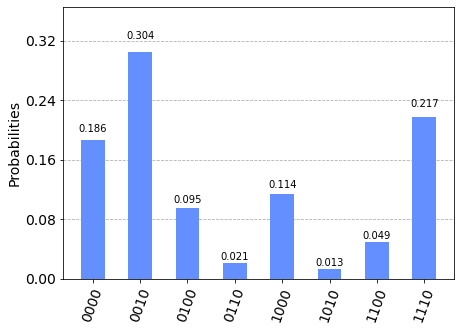

In [51]:
test_job = execute(parameterized_test_circuit, qs, shots = measurements, seed = 1000)
result = test_job.result()
counts = result.get_counts()
plot_histogram(counts)

In [52]:
print(counts)

{'0010': 2436, '1110': 1740, '1000': 909, '0000': 1489, '0100': 756, '0110': 171, '1100': 391, '1010': 108}


In [53]:
print(random_states)

[array([0, 1, 1, 0]), array([1, 1, 1, 1]), array([1, 1, 1, 0]), array([0, 1, 0, 0])]


In [54]:
def cost_function(qubits, epsilon, random_states, counts):
    sum_of_ln = 0
    for i in range(qubits):
        number_string = ''
        for number in output_states[i]:
            number_string += str(number)
        #print(number_string)
        sum_of_ln += np.log(np.maximum(epsilon, counts.get(number_string, epsilon)/measurements))
    result = (-1/qubits)*sum_of_ln
    return result

calculated_cost = cost_function(qubits, 0.01, random_states, counts)
print(calculated_cost)


4.133473806547635


In [66]:
def new_cost_function(qubits, epsilon, random_states, counts):
    sum_of_ln = 0
    for counted_state in range(len(counts)):
        for i in range(qubits):
            number_string = ''
            for number in output_states[i]:
                number_string += str(number)
            sum_of_ln += np.log(np.maximum(epsilon, counts[counted_state].get(number_string, epsilon)/measurements))
    result = (-1/qubits)*sum_of_ln
    return result

#calculated_cost = cost_function(qubits, 0.01, random_states, counts)
#print(calculated_cost)


In [56]:
def optimizable_cost_function(generated_parameters):
    ocf_circuit = ddqcl(layers, qubits)
    #parameterized_ocf_circuit = ocf_circuit.bind_parameters(generated_parameters)
    #parameterized_ocf_circuit.measure(0,0)
    #parameterized_ocf_circuit.measure(1,1)
    #parameterized_ocf_circuit.measure(2,2)
    #parameterized_ocf_circuit.measure(3,3)
    ocf_circuit.measure(0,0)
    ocf_circuit.measure(1,1)
    ocf_circuit.measure(2,2)
    ocf_circuit.measure(3,3)
    ocf_job = execute(ocf_circuit.bind_parameters(generated_parameters), qs, shots = measurements)
    ocf_result = ocf_job.result()
    counts = result.get_counts()
    sum_of_ln = 0
    epsilon = 0.05
    for i in range(qubits):
        number_string = ''
        for number in random_states[i]:
            number_string += str(number)
        #print(number_string)
        sum_of_ln += np.log(np.maximum(epsilon, counts.get(number_string, epsilon)/measurements+1))
    cost = (-1/qubits)*sum_of_ln
    print(cost)
    return cost

In [57]:
generated_parameters

[0.0029132790442663943,
 0.7316261778047009,
 -3.14,
 -0.544474853595504,
 0.00042753658649887915,
 -2.6714284419609666,
 3.14,
 3.14,
 -0.003014556715858021,
 -2.0878222142967244,
 -3.14,
 -3.14,
 0.0030072477356635537,
 -1.8777890265082546,
 0.4838225779260168,
 -3.14]

In [58]:
def initialized_ddqcl(state_vector, layers, qubits):
    qr = QuantumRegister(qubits)
    cr = ClassicalRegister(qubits)
    qc = QuantumCircuit(qr, cr)
    for i in range(len(state_vector)):
        if state_vector[i] == 1:
            qc.x(i)
    for layer in range(layers):
        for i in range(qubits):
            qc.rx(theta_vectors[layer].params[i], i)
            qc.rz(theta_vectors[layer].params[i], i)
            for j in range(i+1, qubits):
                qc.rxx(theta_vectors[layer].params[i], i, j)
        qc.barrier()
    return qc

def get_counts_for_state(state, parameters):
    ddqcl = initialized_ddqcl(state, layers, qubits)
    ddqcl = ddqcl.bind_parameters(parameters)
    ddqcl.measure(0,0)
    ddqcl.measure(1,1)
    ddqcl.measure(2,2)
    ddqcl.measure(3,3)
    ddqcl.draw('mpl')
    ddqcl_job = execute(ddqcl, qs, shots = measurements, seed = 1000)
    ddqcl_result = ddqcl_job.result()
    ddqcl_counts = ddqcl_result.get_counts()
    return ddqcl_counts

Cost: 6.437751649736399 at iteration 0 with parameters:
[-0.28459407826980704, 0.48057882840007293, -2.4596472424557367, 3.0554476166796634, 0.0998595027541074, -0.8482166145158094, 2.888201910457084, 3.0719527295989018, 0.25219114263809284, 0.7327994662181224, -0.6813367740325731, 1.3968593470077877, 0.013537279251561875, 2.5305068465727456, 2.9529196524870587, 2.9070115970074606]
Cost: 6.3757605986145185 at iteration 1 with parameters:
[0.01540592173019295, 0.780578828400073, -2.159647242455737, 3.355447616679663, 0.3998595027541074, -0.5482166145158094, 3.188201910457084, 3.3719527295989016, 0.5521911426380928, 1.0327994662181224, -0.3813367740325731, 1.6968593470077877, 0.3135372792515619, 2.8305068465727454, 3.2529196524870585, 3.2070115970074604]
Cost: 6.367988853923273 at iteration 5 with parameters:
[0.24532229546632328, 0.8876945417712286, -2.2051122226379753, 3.1860964777924257, 0.3367632846289824, -0.549897716405209, 3.075547950451541, 3.4255405654810063, 0.600218543968351, 

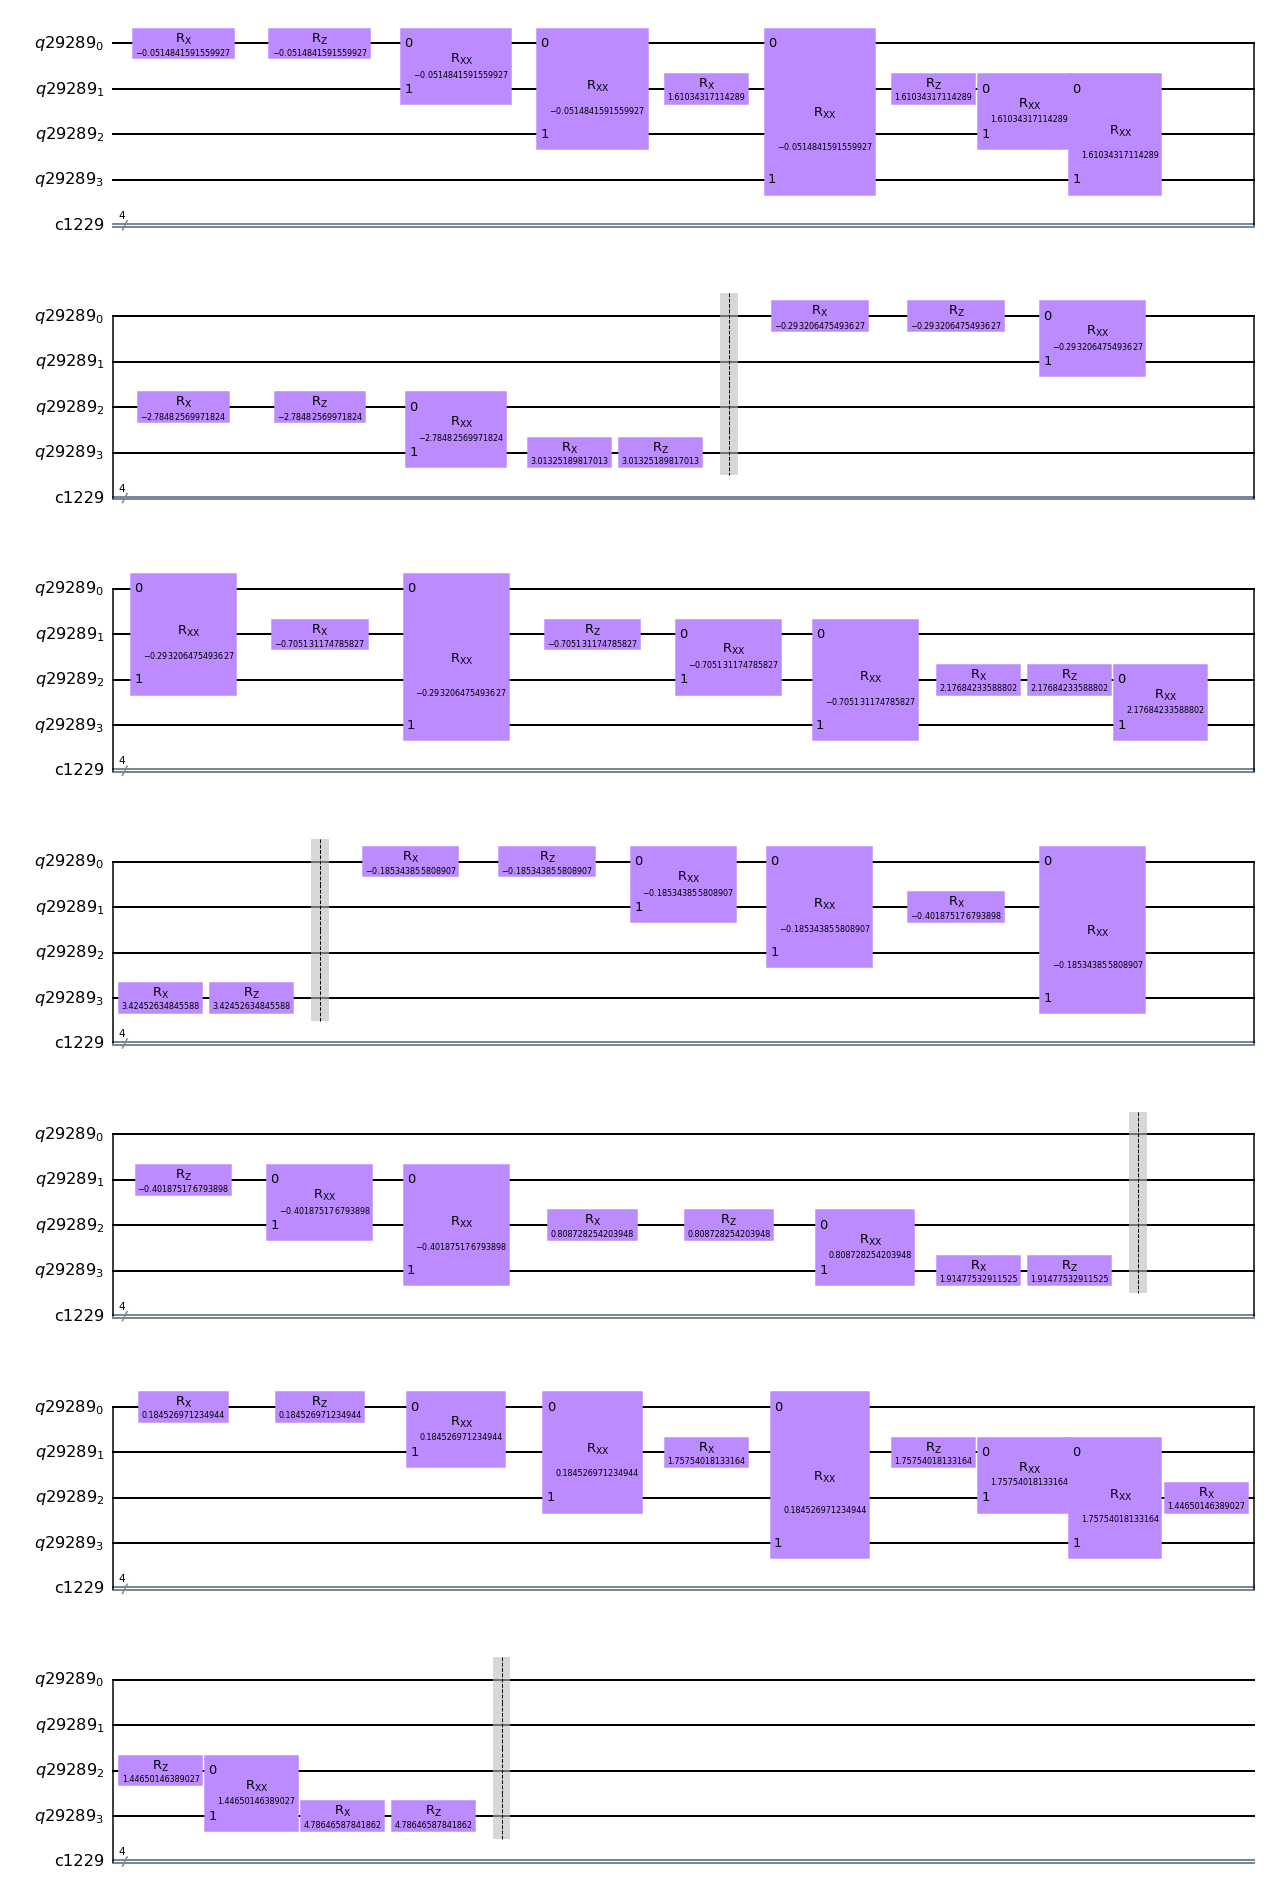

In [67]:
def my_optimizer(current_parameters, delta, iterations, epsilon, best_cost):
    cost_history = []
    #generated_parameters = []
    original_delta = delta
    generated_parameters.append(current_parameters)
    better = 2
    for i in range(iterations):
        cummulative_iterations = 0
        new_generated_parameters = []
        for j in range(qubits*layers):
            if better == 1:
                new_generated_parameters.append(generated_parameters[-1][j] + delta)
            elif better == 0:
                new_generated_parameters.append(generated_parameters[-1][j] - delta)
            else:
                new_generated_parameters.append(generated_parameters[-1][j] + random.uniform(-delta, delta))
        new_counts = []
        new_counts.append(get_counts_for_state(random_states[0], new_generated_parameters))
        new_counts.append(get_counts_for_state(random_states[1], new_generated_parameters))
        new_counts.append(get_counts_for_state(random_states[2], new_generated_parameters))
        new_counts.append(get_counts_for_state(random_states[3], new_generated_parameters))
        new_cost = new_cost_function(qubits, epsilon, random_states, new_counts)
        if new_cost < best_cost:
            cost_history.append(new_cost)
            generated_parameters.append(new_generated_parameters)
            print("Cost: " + str(new_cost) + " at iteration " + str(i) + " with parameters:")
            print(new_generated_parameters)
            best_cost = new_cost
            better = 1
            cummulative_iterations = 0
        elif better == 1:
            better = 0
        else:
            better = 2
            cummulative_iterations = cummulative_iterations + 1
            if cummulative_iterations == 30:
                delta = delta * 1.5
            if cummulative_iterations == 45:
                delta = delta * 1.5
            if cummulative_iterations == 60:
                delta = delta * 1.5
            if cummulative_iterations == 100:
                delta = original_delta
            if cummulative_iterations == 150:
                parameterized_best_circuit = test_circuit.bind_parameters(generated_parameters[-1])
                return parameterized_best_circuit, generated_parameters[-1], cost_history
    parameterized_best_circuit = test_circuit.bind_parameters(generated_parameters[-1])
    return parameterized_best_circuit, generated_parameters[-1], cost_history
last_circuit, best_parameters, cost_history = my_optimizer(theta_values_generator(layers,qubits), 0.3, 1000, 0.2, 10)
last_circuit.draw('mpl')

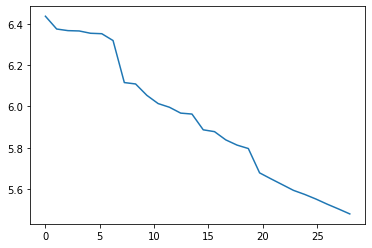

In [68]:
plt.plot(np.linspace(0,len(cost_history),len(cost_history)), cost_history)
plt.show()


Output values for input state [0 1 1 0] which should give 0011:


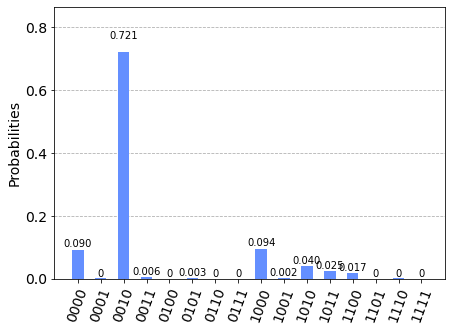

In [69]:
counts_0 = get_counts_for_state(random_states[0], best_parameters)
print("Output values for input state " + str(random_states[0]) +" which should give " + output_states[0] + ":")
plot_histogram(counts_0)

Output values for input state [1 1 1 1] which should give 0101:


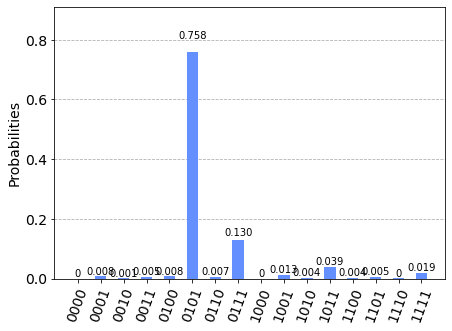

In [70]:
counts_1 = get_counts_for_state(random_states[1], best_parameters)
print("Output values for input state " + str(random_states[1]) +" which should give " + output_states[1] + ":")
plot_histogram(counts_1)

Output values for input state [1 1 1 0] which should give 1010:


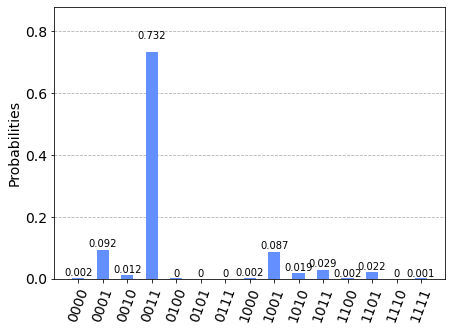

In [71]:
counts_2 = get_counts_for_state(random_states[2], best_parameters)
print("Output values for input state " + str(random_states[2]) +" which should give " + output_states[2] + ":")
plot_histogram(counts_2)

Output values for input state [0 1 0 0] which should give 1100:


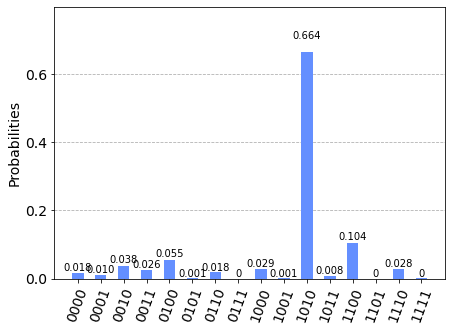

In [72]:
counts_3 = get_counts_for_state(random_states[3], best_parameters)
print("Output values for input state " + str(random_states[3]) +" which should give " + output_states[3] + ":")
plot_histogram(counts_3)

# Second approach

In [73]:
print(best_parameters)

[-0.05148415915599275, 1.6103431711428877, -2.78482569971824, 3.0132518981701337, -0.2932064754936269, -0.7051311747858267, 2.176842335888017, 3.424526348455875, -0.18534385580890686, -0.40187517679389756, 0.8087282542039479, 1.914775329115253, 0.18452697123494372, 1.757540181331641, 1.446501463890275, 4.78646587841862]
